In [1]:
import os
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
import functools
import operator
import matplotlib as mpl
import seaborn as sns
import sklearn.tree
import sklearn.linear_model
import math
import random
from sklearn.externals import joblib
import time
%matplotlib inline

In [2]:
def read_idx(f):
    '''
    Read an IDX format data file - See http://yann.lecun.com/exdb/mnist/ for format specification.
        f: File name to read from. Can be either a .gz (gzip compressed) file or file without extension (uncompressed)
        returns: Numpy NDArray of data. The shape and dtype will match the data in the IDX file.
    '''
    type_dict = {
        0x08: np.dtype(np.uint8),
        0x09: np.dtype(np.int8),
        0x0B: np.dtype('>i2'), # short (2 bytes) 
        0x0C: np.dtype('>i4'), # int (4 bytes) 
        0x0D: np.dtype('>f4'), # float (4 bytes) 
        0x0E: np.dtype('>f8'), # double (8 bytes)
    }
    
    open_fn_dict = {'': open, '.gz': gzip.open}
    ext = os.path.splitext(f)[-1]    
    open_fn = open_fn_dict.get(ext)
    assert open_fn, f"Invalid extension in file {f} - do not know how to open this file"
    
    with open_fn(f, 'rb') as fd:
        # read magic number - first 4 bytes
        magic_num = fd.read(4)        
        assert magic_num[:2] == b'\x00\x00', f'Magic number in {f} does not match expected MNIST format 0x00 0x00.'
        
        # byte 4 is number of dimensions
        num_dimensions = magic_num[3]
        
        # byte 3 is dtype code.  Lookup the Numpy dtype using type_dict 
        dt = type_dict.get(magic_num[2])
        assert dt, f"3rd byte of magic number {magic_num[2]} in {f} is not valid MNIST type"
        
        #next set of UINTs are dimensions - read each, convert to int 
        dimensions = [int.from_bytes(fd.read(4), 'big') for i in range(num_dimensions)]  
        
        # total size of the data in bytes - (d1 * d2 * ... dn) * (size of dtype)
        size = functools.reduce(operator.mul, dimensions) * dt.itemsize
        assert size > 0, f"Invalid dimensions {dimensions} with resulting size 0 in file {f}"
        
        # read all data. 
        data = fd.read()
        assert len(data) == size, f'Expected {size} bytes from {f} but got {len(data)} bytes.'
        
        # build the ndarray from data
        bytes_array = np.frombuffer(data, dtype=dt).reshape(dimensions)
        return bytes_array

def show_digits(images, labels, nrows=6, ncols=5, figsize=(16,14)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for ax, image, label in zip(axs.ravel(), images, labels):
        if image.ndim == 1:      
            n = int(math.sqrt(image.shape[0]))
            image = image.reshape((n, n))
        ax.imshow(image, cmap=mpl.cm.gray)
        ax.set_title(f'Label = {label}')
        ax.axis('off')
    plt.tight_layout()
        

In [3]:
d = r'DATA\MNIST' 

y_train = read_idx(os.path.join(d, 'train-labels-idx1-ubyte.gz'))
train_images = read_idx(os.path.join(d, 'train-images-idx3-ubyte.gz'))
X_train = train_images.reshape((train_images.shape[0], train_images.shape[1]*train_images.shape[2]))

y_test = read_idx(os.path.join(d, 't10k-labels-idx1-ubyte.gz'))
test_images = read_idx(os.path.join(d, 't10k-images-idx3-ubyte.gz'))
X_test = test_images.reshape((test_images.shape[0], test_images.shape[1]*test_images.shape[2]))

1.2325150966644287


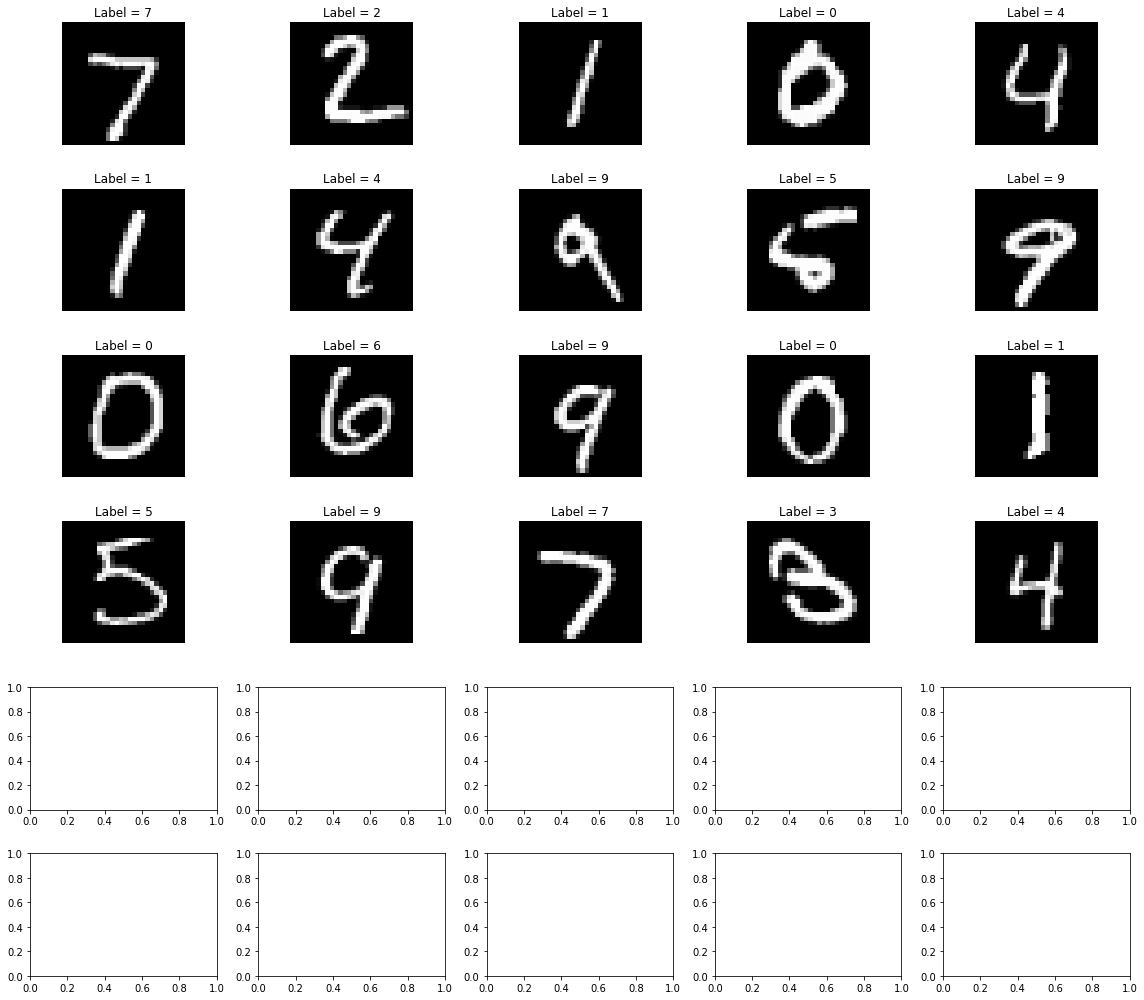

In [4]:
start = time.time()
show_digits(X_test[:20], y_test[:20])
end = time.time()

print(end-start)

## Decision Trees

In [5]:
'''
Checks if file with trained model exists. If it exists, it reads the file and loads the trained model. If it doesn't exist,
it trains the model, writes to a file, and then reads the file and loads the trained model.
'''

fd = 'trained_model.pkl'
if os.path.exists(fd):
    clf2 = joblib.load(fd)
    print(f'{fd} exists.')
else:
    clf2 = sklearn.tree.DecisionTreeClassifier()
    clf2.fit(X_train, y_train)
    joblib.dump(clf2, fd)
    

trained_model.pkl exists.


In [6]:
y_predict = clf2.predict(X_test)

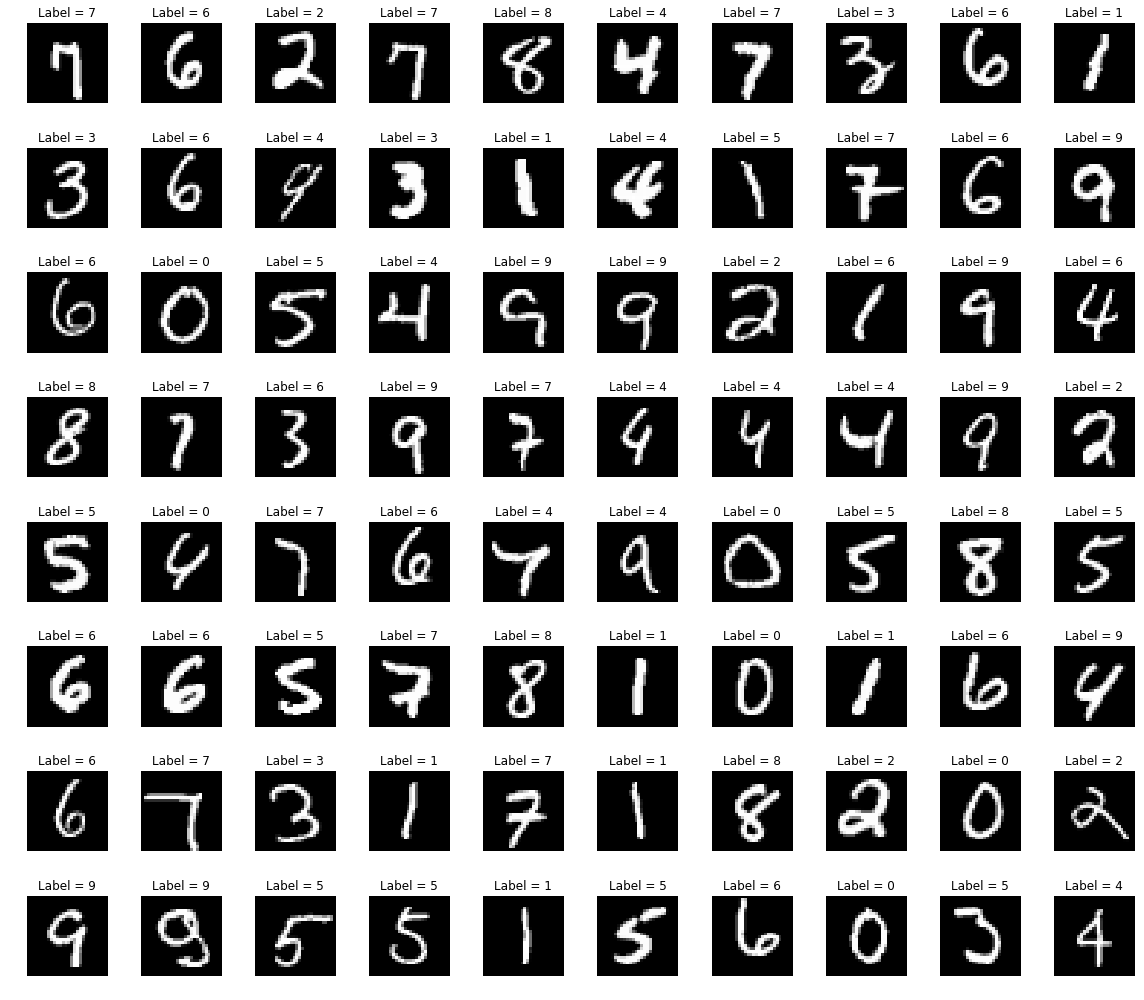

In [7]:
show_digits(test_images[80:], y_predict[80:], nrows=8, ncols=10)

In [8]:
def get_accuracy(predict):
    correct = np.sum(y_test == predict)
    total = y_test.shape[0]
    return correct*100/total

Text(0,0.5,'Distribution')

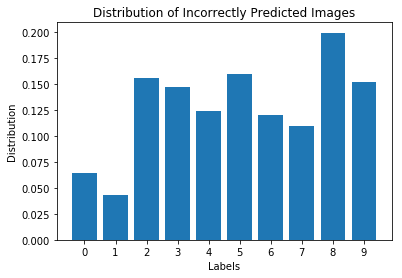

In [9]:
y_match = (y_test == y_predict)
incorrect = {}
for i in range(10):
    ixs = np.where(y_test == i)[0]
    incorrect[i] = np.sum(y_test[ixs] != y_predict[ixs]) / ixs.shape[0]
    
plt.bar(list(incorrect.keys()), list(incorrect.values()), tick_label = list(range(10)))
plt.title('Distribution of Incorrectly Predicted Images')
plt.xlabel('Labels')
plt.ylabel('Distribution')

In [23]:
accuracy = {}
train_time = {}
training_all_indices = np.arange(X_train.shape[0])
np.random.shuffle(training_all_indices)
num_samples = 10

for i in range(1, num_samples + 1):
    sample_size = i * X_train.shape[0] // num_samples
    clf = sklearn.tree.DecisionTreeClassifier()
    start = time.time()
    print(sample_size)
    clf.fit(X_train[training_all_indices[:sample_size]], y_train[training_all_indices[:sample_size]])
    end = time.time()
    train_time[sample_size / 1000] = (end - start)
    accuracy[sample_size / 1000] = get_accuracy(clf.predict(X_test))
accuracy, train_time

6000
12000
18000
24000
30000
36000
42000
48000
54000
60000


({6.0: 79.129999999999995,
  12.0: 82.469999999999999,
  18.0: 83.049999999999997,
  24.0: 84.930000000000007,
  30.0: 85.459999999999994,
  36.0: 86.25,
  42.0: 86.659999999999997,
  48.0: 86.760000000000005,
  54.0: 87.379999999999995,
  60.0: 87.810000000000002},
 {6.0: 1.0530009269714355,
  12.0: 2.7315962314605713,
  18.0: 4.049851655960083,
  24.0: 6.522200584411621,
  30.0: 8.749318361282349,
  36.0: 11.28572678565979,
  42.0: 13.818138837814331,
  48.0: 17.674803733825684,
  54.0: 19.28233289718628,
  60.0: 23.096959352493286})

Text(0,0.5,'Model Accuracy (Percent)')

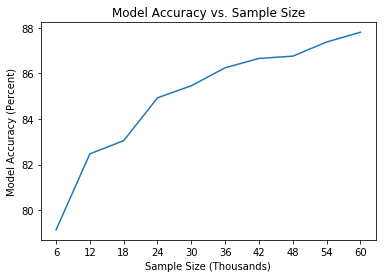

In [24]:
plt.plot(list(accuracy.keys()), list(accuracy.values()))
plt.xticks(list(accuracy.keys()))
plt.title("Model Accuracy vs. Sample Size")
plt.xlabel("Sample Size (Thousands)")
plt.ylabel("Model Accuracy (Percent)")


Text(0,0.5,'Training Time (Seconds)')

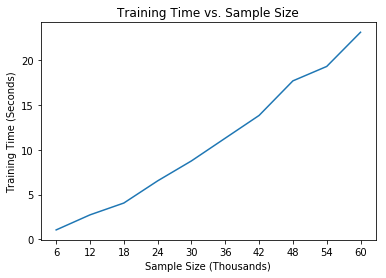

In [26]:
plt.plot(list(train_time.keys()), list(train_time.values()))
plt.xticks(list(train_time.keys()))
plt.title("Training Time vs. Sample Size")
plt.xlabel("Sample Size (Thousands)")
plt.ylabel("Training Time (Seconds)")

(array([ 5923.,  6742.,  5958.,  6131.,  5842.,  5421.,  5918.,  6265.,
         5851.,  5949.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

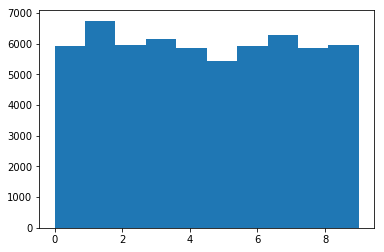

In [28]:
plt.hist(y_train)

In [57]:
num_samples = 10
for i in range(1, num_samples + 1):
    sample_size = i * X_train.shape[0] // num_samples
    y = y_train[:sample_size]
    b = np.bincount(y)
    c = np.nonzero(b)[0]
    freq = sorted(zip(b[c], c))
    print(f'Sample Size = {sample_size}, Min = {freq[0]}, Max = {freq[-1]}')

Sample Size = 6000, Min = (514, 5), Max = (671, 1)
Sample Size = 12000, Min = (1048, 5), Max = (1351, 1)
Sample Size = 18000, Min = (1587, 5), Max = (2051, 1)
Sample Size = 24000, Min = (2144, 5), Max = (2732, 1)
Sample Size = 30000, Min = (2709, 5), Max = (3423, 1)
Sample Size = 36000, Min = (3230, 5), Max = (4113, 1)
Sample Size = 42000, Min = (3784, 5), Max = (4799, 1)
Sample Size = 48000, Min = (4324, 5), Max = (5470, 1)
Sample Size = 54000, Min = (4872, 5), Max = (6112, 1)
Sample Size = 60000, Min = (5421, 5), Max = (6742, 1)


In [97]:

def is_sorted(num_list):
    index = 0
    while index < (len(num_list) - 1):
        if(num_list[index] > num_list[index + 1]):
            return False
        index += 1
    return True

def is_sorted2(l):
    return all(b >= a for a, b in zip(l, l[1:]))

def is_sorted3(l):
    li = iter(l)
    next(li)
    return all(b>=a for a, b in zip(l, li))

def is_sorted4(l):
    return np.all(np.diff(l) >= 0)

In [85]:
a = np.arange(1000000)
a[-1] = 0
al = list(a)

In [98]:
%time is_sorted4(a)

Wall time: 3.99 ms


False

In [86]:
%time is_sorted(a)
%time is_sorted(al)

Wall time: 334 ms
Wall time: 205 ms


False

In [87]:
%time is_sorted2(a)
%time is_sorted2(al)

Wall time: 154 ms
Wall time: 80 ms


False

In [88]:
%time is_sorted3(a)
%time is_sorted3(al)

Wall time: 152 ms
Wall time: 70 ms


False